# Principal Component Analysis and Random Forest 

The goal of this notebook is to perform PCA and Random Forest to provide insight into our
full data. 

## Data Exploration

In [1]:
# Define some packages and functions that will be used throughout the notebook

import pandas as pd
import numpy as np
import statistics
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt


def most_common(row):
    return max(set(row), key=row.count)

def get_seconds(row):
    return row.second

def sort_dt(row):
    return sorted(row)

def get_td_mean(row):
    td = 0
    if len(row) > 2:
        for i in range (0,len(row)-1):
            td += row[i+1]-row[i]
        return td/(len(row)-1)
    else:
        return 0
        
def get_td_sd(row):
    sd = 0
    new_list = []
    if len(row) > 2:
        for i in range (0,len(row)-1):
            new_list.append(row[i+1]-row[i])
        return statistics.stdev(new_list)
    else:
        return 0
        

In [2]:
# import original data file from 23rd of May 2019

data = pd.read_csv("/Users/siboraseranaj/Downloads/stingar_full-20190523(2).csv")
data.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,app,command,data,dest_ip,dest_port,dionaea_action,direction,hash,ids_type,...,ssh_version,tags,timestamp,transport,type,url,username,vendor_product,d_time,d_time_window
0,0,dionaea,NaN,NaN,172.18.0.2,1433,accept,inbound,NaN,network,...,NaN,NaN,2019-05-23T07:25:00.099290,tcp,dionaea.connections,NaN,NaN,Dionaea,2019-05-23 03:25:00,2019-05-23 03:25:00
1,1,dionaea,NaN,NaN,172.18.0.2,445,accept,inbound,NaN,network,...,NaN,NaN,2019-05-23T07:25:00.178565,tcp,dionaea.connections,NaN,NaN,Dionaea,2019-05-23 03:25:00,2019-05-23 03:25:00
2,2,dionaea,NaN,NaN,172.18.0.2,445,accept,inbound,NaN,network,...,NaN,NaN,2019-05-23T07:25:00.511274,tcp,dionaea.connections,NaN,NaN,Dionaea,2019-05-23 03:25:00,2019-05-23 03:25:00
3,3,dionaea,NaN,NaN,172.18.0.2,1433,accept,inbound,NaN,network,...,NaN,NaN,2019-05-23T07:25:01.257961,tcp,dionaea.connections,NaN,NaN,Dionaea,2019-05-23 03:25:01,2019-05-23 03:25:00
4,4,dionaea,NaN,NaN,172.18.0.2,445,accept,inbound,NaN,network,...,NaN,NaN,2019-05-23T07:25:01.582025,tcp,dionaea.connections,NaN,NaN,Dionaea,2019-05-23 03:25:01,2019-05-23 03:25:00


In [3]:
data.columns

Index(['Unnamed: 0', 'app', 'command', 'data', 'dest_ip', 'dest_port',
       'dionaea_action', 'direction', 'hash', 'ids_type', 'protocol',
       'request_url', 'sensor', 'severity', 'signature', 'src_ip', 'src_port',
       'ssh_password', 'ssh_username', 'ssh_version', 'tags', 'timestamp',
       'transport', 'type', 'url', 'username', 'vendor_product', 'd_time',
       'd_time_window'],
      dtype='object')

In [4]:
data.dtypes

Unnamed: 0         int64
app               object
command           object
data              object
dest_ip           object
dest_port          int64
dionaea_action    object
direction         object
hash              object
ids_type          object
protocol          object
request_url       object
sensor            object
severity          object
signature         object
src_ip            object
src_port           int64
ssh_password      object
ssh_username      object
ssh_version       object
tags              object
timestamp         object
transport         object
type              object
url               object
username          object
vendor_product    object
d_time            object
d_time_window     object
dtype: object

## Feature Engineering

First we engineered features based on the variables we already had. Most of our data was string data, so it was neccessary step. 
The features we created were:

    1. mean_time_difference which shows the mean difference in time between two consecutive          attacks from the same IP
    2. sd_time_difference which shows the standard deviation in time difference between two          consecutive attacks from the same ip
    3. length_username which shows the length of the username input by the attacker
    4. length_password which shows the length of the password input by the attacker
    5. sensor_number which shows the number of sensors hit by the attacker 

 

In [5]:
data['d_time'] = pd.to_datetime(data['d_time']).values.astype(np.int64)

In [6]:
# create feature mean_time_difference which shows the mean difference in time between two consecutive attacks from the same ip

data_grouped_td = data[['src_ip','d_time']].groupby('src_ip',as_index = False).agg({'d_time':lambda x: x.tolist()})
data_grouped_td['d_time'] = data_grouped_td['d_time'].apply(sort_dt)
data_grouped_td['d_time'] = data_grouped_td['d_time'].apply(get_td_mean)
data_grouped_td['d_time'] = pd.to_datetime(data_grouped_td['d_time'], unit='ns')
data_grouped_td['d_time'] = data_grouped_td['d_time'].apply(get_seconds)
data_grouped_td = data_grouped_td.rename({'d_time':'mean_time_difference'},axis = 1)
data_grouped_td.head()

,src_ip,mean_time_difference
0,1.0.139.35,41
1,1.0.157.0,52
2,1.0.182.29,3
3,1.0.187.45,1
4,1.0.190.251,41


In [7]:
# create feature sd_time_difference which shows the standard deviation in time difference between two consecutive attacks from the same ip

data_grouped_sd = data[['src_ip','d_time']].groupby('src_ip',as_index = False).agg({'d_time':lambda x: x.tolist()})
data_grouped_sd['d_time'] = data_grouped_sd['d_time'].apply(sort_dt)
data_grouped_sd['d_time'] = data_grouped_sd['d_time'].apply(get_td_sd)
data_grouped_sd['d_time'] = pd.to_datetime(data_grouped_sd['d_time'], unit='ns')
data_grouped_sd['d_time'] = data_grouped_sd['d_time'].apply(get_seconds)
data_grouped_sd = data_grouped_sd.rename({'d_time':'sd_time_difference'},axis = 1)
data_grouped_sd.head() 

,src_ip,sd_time_difference
0,1.0.139.35,11
1,1.0.157.0,17
2,1.0.182.29,27
3,1.0.187.45,2
4,1.0.190.251,11


In [8]:
data_grouped = data[['src_ip','d_time']].groupby('src_ip',as_index = False).agg({'d_time':np.mean})
data_grouped['d_time'] = pd.to_datetime(data_grouped['d_time'], unit='ns')
data_grouped.head()

,src_ip,d_time
0,1.0.139.35,2019-05-23 00:05:46.249999872
1,1.0.157.0,2019-05-23 05:48:53.500000256
2,1.0.182.29,2019-05-23 11:29:27.666666752
3,1.0.187.45,2019-05-23 06:20:04.249999872
4,1.0.190.251,2019-05-23 04:13:35.749999872


In [9]:
data_grouped1 = data[['src_ip','d_time']].groupby('src_ip',as_index = False).agg({'d_time':np.std})
data_grouped1['d_time'] = pd.to_datetime(data_grouped1['d_time'], unit='ns')
data_grouped1['d_time'] = data_grouped1['d_time'].apply(get_seconds)
data_grouped1.head()

,src_ip,d_time
0,1.0.139.35,11.0
1,1.0.157.0,26.0
2,1.0.182.29,12.0
3,1.0.187.45,2.0
4,1.0.190.251,11.0


In [10]:
# Find the number of sensor hit by the attacker 
def rem_dups(array):
    myset = set(array)
    return len(list(myset))

data_grouped2 = data[['sensor','src_ip']].groupby('src_ip',as_index = False).agg({'sensor':lambda x: x.tolist()})
data_grouped2['sensor_number'] = data_grouped2['sensor'].apply(rem_dups)
data_grouped2['sensor_number'].value_counts()

1     14384
2      1632
3       473
4       183
5        98
6        65
7        29
8        26
9        21
12       17
10       11
11       10
20       10
13        5
18        4
19        4
14        3
16        2
21        2
30        1
17        1
22        1
15        1
Name: sensor_number, dtype: int64

In [11]:
data_final = data_grouped.merge(data_grouped1, left_on='src_ip', right_on='src_ip')
data_final = data_final.merge(data_grouped_td,left_on='src_ip', right_on='src_ip')
data_final = data_final.merge(data_grouped_sd,left_on='src_ip', right_on='src_ip')
data_final = data_final.merge(data_grouped2,left_on='src_ip', right_on='src_ip')
data_final = data_final.rename({'d_time_x':'mean_time_of_attack','d_time_y':'sd_time_of_attack','sensor':'all_sensors'},axis = 1)

In [12]:
data_final.head()

,src_ip,mean_time_of_attack,sd_time_of_attack,mean_time_difference,sd_time_difference,all_sensors,sensor_number
0,1.0.139.35,2019-05-23 00:05:46.249999872,11.0,41,11,"[49eed2a1-83a4-4968-90cf-1235dd6f88fa, 49eed2a...",1
1,1.0.157.0,2019-05-23 05:48:53.500000256,26.0,52,17,"[fdd6134e-08a7-49d3-90d7-5499916077a4, fdd6134...",1
2,1.0.182.29,2019-05-23 11:29:27.666666752,12.0,3,27,"[a8fed55b-b5f2-4bbc-b77e-b0feb4d1caee, a8fed55...",1
3,1.0.187.45,2019-05-23 06:20:04.249999872,2.0,1,2,"[a8fed55b-b5f2-4bbc-b77e-b0feb4d1caee, a8fed55...",1
4,1.0.190.251,2019-05-23 04:13:35.749999872,11.0,41,11,"[49eed2a1-83a4-4968-90cf-1235dd6f88fa, 49eed2a...",1


In [13]:
data_final.drop(["mean_time_of_attack", "sd_time_of_attack"], axis = 1)

,src_ip,mean_time_difference,sd_time_difference,all_sensors,sensor_number
0,1.0.139.35,41,11,"[49eed2a1-83a4-4968-90cf-1235dd6f88fa, 49eed2a...",1
1,1.0.157.0,52,17,"[fdd6134e-08a7-49d3-90d7-5499916077a4, fdd6134...",1
2,1.0.182.29,3,27,"[a8fed55b-b5f2-4bbc-b77e-b0feb4d1caee, a8fed55...",1
3,1.0.187.45,1,2,"[a8fed55b-b5f2-4bbc-b77e-b0feb4d1caee, a8fed55...",1
4,1.0.190.251,41,11,"[49eed2a1-83a4-4968-90cf-1235dd6f88fa, 49eed2a...",1
5,1.0.201.216,43,34,"[fdd6134e-08a7-49d3-90d7-5499916077a4, fdd6134...",1
6,1.0.205.239,41,11,"[fdd6134e-08a7-49d3-90d7-5499916077a4, fdd6134...",1
7,1.0.241.191,42,11,"[a8fed55b-b5f2-4bbc-b77e-b0feb4d1caee, a8fed55...",1
8,1.0.251.143,54,41,"[49797144-df1a-424a-841f-3b3faaf19506, 4979714...",3
9,1.1.173.11,0,0,[113abfec-95f0-4fb9-ae48-86a22a4ff7ee],1


In [14]:
data_final.drop(["mean_time_of_attack", "sd_time_of_attack", "all_sensors"], axis = 1, inplace= True)

In [15]:
data_final.head()

,src_ip,mean_time_difference,sd_time_difference,sensor_number
0,1.0.139.35,41,11,1
1,1.0.157.0,52,17,1
2,1.0.182.29,3,27,1
3,1.0.187.45,1,2,1
4,1.0.190.251,41,11,1


In [16]:
new = data[["ssh_username", "src_ip"]].dropna()

In [17]:
new["length_username"] = new["ssh_username"].apply(len)

In [18]:
user_length = new.groupby("src_ip").mean()

In [19]:
data_final.head()

,src_ip,mean_time_difference,sd_time_difference,sensor_number
0,1.0.139.35,41,11,1
1,1.0.157.0,52,17,1
2,1.0.182.29,3,27,1
3,1.0.187.45,1,2,1
4,1.0.190.251,41,11,1


In [20]:
current = pd.merge(user_length, data_final, how = "outer", on = "src_ip")

In [21]:
current.head()

,src_ip,length_username,mean_time_difference,sd_time_difference,sensor_number
0,1.100.70.252,6.000000,0,0,1
1,1.109.197.121,3.000000,0,0,1
2,1.158.42.147,5.461165,10,17,1
3,1.170.31.204,5.482587,12,20,1
4,1.179.137.10,5.000000,0,0,1


In [22]:
current['length_username'].fillna(value = current['length_username'].mean(), inplace = True)

In [23]:
current.head()

,src_ip,length_username,mean_time_difference,sd_time_difference,sensor_number
0,1.100.70.252,6.000000,0,0,1
1,1.109.197.121,3.000000,0,0,1
2,1.158.42.147,5.461165,10,17,1
3,1.170.31.204,5.482587,12,20,1
4,1.179.137.10,5.000000,0,0,1


In [24]:
new_command = data[['src_ip', 'command']]
new_command.dropna(inplace = True)
new_command['length_command'] = new_command['command'].apply(len) 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
feature = new_command.groupby('src_ip').mean()

In [26]:
current = pd.merge(current, feature, how = 'outer', on = "src_ip")

In [27]:
current.head()

,src_ip,length_username,mean_time_difference,sd_time_difference,sensor_number,length_command
0,1.100.70.252,6.000000,0,0,1,NaN
1,1.109.197.121,3.000000,0,0,1,NaN
2,1.158.42.147,5.461165,10,17,1,NaN
3,1.170.31.204,5.482587,12,20,1,NaN
4,1.179.137.10,5.000000,0,0,1,NaN


In [28]:
current['length_command'].fillna(value = current['length_command'].mean(), inplace = True)

In [29]:
current.head()

,src_ip,length_username,mean_time_difference,sd_time_difference,sensor_number,length_command
0,1.100.70.252,6.000000,0,0,1,170.090011
1,1.109.197.121,3.000000,0,0,1,170.090011
2,1.158.42.147,5.461165,10,17,1,170.090011
3,1.170.31.204,5.482587,12,20,1,170.090011
4,1.179.137.10,5.000000,0,0,1,170.090011


In [30]:
data['app'].value_counts()

cowrie      1261534
dionaea      204639
amun           8812
rdphoney       1407
glastopf        610
conpot           39
Name: app, dtype: int64

In [31]:
counts = data['app'].value_counts()
res = data[~data['app'].isin(counts[counts < 27].index)]
res['app'].value_counts()
honeypot = res[['app', 'src_ip']]
honeypot.head()

,app,src_ip
0,dionaea,112.133.244.33
1,dionaea,1.52.125.248
2,dionaea,171.221.41.21
3,dionaea,27.185.177.235
4,dionaea,36.72.215.37


In [32]:
current.head()

,src_ip,length_username,mean_time_difference,sd_time_difference,sensor_number,length_command
0,1.100.70.252,6.000000,0,0,1,170.090011
1,1.109.197.121,3.000000,0,0,1,170.090011
2,1.158.42.147,5.461165,10,17,1,170.090011
3,1.170.31.204,5.482587,12,20,1,170.090011
4,1.179.137.10,5.000000,0,0,1,170.090011


In [33]:
honeypot['app'].value_counts()
honeypot.groupby('src_ip')

In [34]:
new_current = pd.merge(current, honeypot, how = 'inner', on = 'src_ip')
new_current.head()

,src_ip,length_username,mean_time_difference,sd_time_difference,sensor_number,length_command,app
0,1.100.70.252,6.000000,0,0,1,170.090011,cowrie
1,1.100.70.252,6.000000,0,0,1,170.090011,cowrie
2,1.109.197.121,3.000000,0,0,1,170.090011,cowrie
3,1.109.197.121,3.000000,0,0,1,170.090011,cowrie
4,1.158.42.147,5.461165,10,17,1,170.090011,cowrie


In [35]:
current

,src_ip,length_username,mean_time_difference,sd_time_difference,sensor_number,length_command
0,1.100.70.252,6.000000,0,0,1,170.090011
1,1.109.197.121,3.000000,0,0,1,170.090011
2,1.158.42.147,5.461165,10,17,1,170.090011
3,1.170.31.204,5.482587,12,20,1,170.090011
4,1.179.137.10,5.000000,0,0,1,170.090011
5,1.229.12.206,2.000000,0,0,1,170.090011
6,1.232.77.181,2.000000,0,0,1,170.090011
7,1.34.173.249,5.568627,11,18,1,170.090011
8,1.60.102.174,5.500000,21,46,2,170.090011
9,101.251.197.238,2.000000,0,0,1,170.090011


In [36]:
dat = data.groupby('src_ip')[['src_ip', 'app']].head()
temp = dat.drop_duplicates()

In [37]:
let = pd.get_dummies(temp['app'])
let.head()

,amun,conpot,cowrie,dionaea,glastopf,rdphoney
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0


In [38]:
det = pd.concat([let,temp], axis = 1)
det['app'].value_counts()
counts = det['app'].value_counts()
det = det[~det['app'].isin(counts[counts < 100].index)]
det['app'].value_counts()

dionaea     15019
cowrie       1381
amun          356
glastopf      237
rdphoney      176
Name: app, dtype: int64

In [39]:
current.columns

Index(['src_ip', 'length_username', 'mean_time_difference',
       'sd_time_difference', 'sensor_number', 'length_command'],
      dtype='object')

In [40]:
current.drop_duplicates('src_ip', inplace = True)

In [41]:
current

,src_ip,length_username,mean_time_difference,sd_time_difference,sensor_number,length_command
0,1.100.70.252,6.000000,0,0,1,170.090011
1,1.109.197.121,3.000000,0,0,1,170.090011
2,1.158.42.147,5.461165,10,17,1,170.090011
3,1.170.31.204,5.482587,12,20,1,170.090011
4,1.179.137.10,5.000000,0,0,1,170.090011
5,1.229.12.206,2.000000,0,0,1,170.090011
6,1.232.77.181,2.000000,0,0,1,170.090011
7,1.34.173.249,5.568627,11,18,1,170.090011
8,1.60.102.174,5.500000,21,46,2,170.090011
9,101.251.197.238,2.000000,0,0,1,170.090011


In [42]:
head = data.groupby('src_ip').count()
head.head()
head.reset_index(inplace = True)
val = head[['src_ip', 'app']]
val.head()

,src_ip,app
0,1.0.139.35,4
1,1.0.157.0,4
2,1.0.182.29,3
3,1.0.187.45,4
4,1.0.190.251,4


In [43]:
current = pd.merge(current, val, how = 'inner', on = 'src_ip')

In [44]:
current.rename(columns={'app':'daily_frequency'}, inplace=True)

In [45]:
current

,src_ip,length_username,mean_time_difference,sd_time_difference,sensor_number,length_command,daily_frequency
0,1.100.70.252,6.000000,0,0,1,170.090011,2
1,1.109.197.121,3.000000,0,0,1,170.090011,2
2,1.158.42.147,5.461165,10,17,1,170.090011,284
3,1.170.31.204,5.482587,12,20,1,170.090011,281
4,1.179.137.10,5.000000,0,0,1,170.090011,2
5,1.229.12.206,2.000000,0,0,1,170.090011,4
6,1.232.77.181,2.000000,0,0,1,170.090011,4
7,1.34.173.249,5.568627,11,18,1,170.090011,71
8,1.60.102.174,5.500000,21,46,2,170.090011,4
9,101.251.197.238,2.000000,0,0,1,170.090011,2


In [46]:
new = data[['src_ip', 'ssh_password']]
new.head()

,src_ip,ssh_password
0,112.133.244.33,NaN
1,1.52.125.248,NaN
2,171.221.41.21,NaN
3,27.185.177.235,NaN
4,36.72.215.37,NaN


In [47]:
new_data = data[['src_ip', 'ssh_password']]
new_data.head()
new_data.dropna(inplace = True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
new_data['length_password'] = new_data['ssh_password'].apply(len)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [49]:
new_data.drop(['ssh_password'], axis = 1, inplace = True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [50]:
new_data.drop_duplicates(inplace= True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [51]:
new_data.head()

,src_ip,length_password
357,198.199.89.115,6
358,198.199.89.115,5
359,198.199.89.115,23
361,198.199.89.115,31
362,198.199.89.115,15


In [52]:
current = pd.merge(current, new_data, how = 'outer', on = 'src_ip')
current['length_password'].fillna(value = current['length_password'].mean(), inplace = True)

In [53]:
current.drop_duplicates(inplace= True)
current.drop_duplicates('src_ip', inplace= True)
current.head()

,src_ip,length_username,mean_time_difference,sd_time_difference,sensor_number,length_command,daily_frequency,length_password
0,1.100.70.252,6.000000,0,0,1,170.090011,2,8.0
1,1.109.197.121,3.000000,0,0,1,170.090011,2,6.0
2,1.158.42.147,5.461165,10,17,1,170.090011,284,7.0
10,1.170.31.204,5.482587,12,20,1,170.090011,281,6.0
19,1.179.137.10,5.000000,0,0,1,170.090011,2,6.0


In [54]:
dat_t = data.groupby('src_ip')['dest_port'].nunique()
new_dat_t = dat_t.reset_index()
new_dat_t.head()

,src_ip,dest_port
0,1.0.139.35,1
1,1.0.157.0,1
2,1.0.182.29,1
3,1.0.187.45,1
4,1.0.190.251,1


In [55]:
current = pd.merge(new_dat_t, current, how = 'inner', on = 'src_ip')

In [56]:
current['dest_port'].value_counts()

1     16713
2       230
3        18
5         6
4         5
12        4
9         2
14        1
7         1
6         1
19        1
16        1
Name: dest_port, dtype: int64

In [57]:
current.rename(columns={'dest_port':'dest_port_number'}, inplace=True)

In [58]:
#current['length_command'].value_counts()

In [59]:
#current['length_password'].value_counts()

In [119]:
current['length_username'].value_counts()

6.503028     16312
6.000000        97
5.000000        89
5.756098        43
7.000000        40
4.000000        39
2.000000        32
3.000000        31
5.500000        23
8.000000        22
5.333333        13
9.000000        12
6.500000        12
5.666667        10
10.000000        7
4.500000         7
23.000000        6
22.555556        6
5.444444         4
5.300000         4
5.250000         4
7.333333         3
23.555556        3
7.500000         3
19.666667        3
4.333333         3
5.555556         3
23.666667        3
6.200000         3
22.888889        3
             ...  
6.069231         1
6.222222         1
4.395833         1
5.875000         1
6.243243         1
5.047619         1
5.437500         1
5.640000         1
6.166667         1
9.500000         1
13.000000        1
20.000000        1
5.869565         1
5.340000         1
5.416667         1
5.466667         1
4.888889         1
6.066667         1
5.068063         1
5.854167         1
22.111111        1
4.125000    

## PCA - all honeypots

This was my first attempt on Principal Component Analysis. PCA is a statistical procedure that uses orthogonal transformation to convert many possibly correlated numerical variables into a specified number of linearly uncorrelated variables. These variables are called principal components. In this analysis I perform PCA on data from all the honeypots, and my target is signature.

In [120]:
# Import neccessary libraries for PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [121]:
# We need to create a target in order to perform PCA
# Find most common signature occuring for each ip
signature = data[['src_ip', 'signature']]
signature_grouped = signature.groupby('src_ip', as_index = False).agg({'signature':lambda x: x.tolist()})
signature_grouped['signature'] = signature_grouped['signature'].apply(most_common)
signature_grouped.head()

,src_ip,signature
0,1.0.139.35,Connection to Honeypot
1,1.0.157.0,Connection to Honeypot
2,1.0.182.29,Connection to Honeypot
3,1.0.187.45,Connection to Honeypot
4,1.0.190.251,Connection to Honeypot


In [122]:
# Create new column named target which is basically a code for each signature
# (PCA only accepts numerical values)

signature_grouped['signature'].unique()
def target(row):
    if row == 'Connection to Honeypot':
        return 1
    elif row == 'SSH login attempted on cowrie honeypot':
        return 2
    elif row == 'SSH session on cowrie honeypot':
        return 3
    elif row == 'command attempted on cowrie honeypot':
        return 4
    else:
        return 5
signature_grouped['target'] = signature_grouped['signature'].apply(target) 
signature_grouped.head()

,src_ip,signature,target
0,1.0.139.35,Connection to Honeypot,1
1,1.0.157.0,Connection to Honeypot,1
2,1.0.182.29,Connection to Honeypot,1
3,1.0.187.45,Connection to Honeypot,1
4,1.0.190.251,Connection to Honeypot,1


In [123]:
current = pd.merge(signature_grouped, current, how = 'inner', on = 'src_ip')

In [124]:
current = current.drop(['signature'], axis = 1)
current['target'].value_counts()

1    15623
3     1050
2      165
4      144
5        1
Name: target, dtype: int64

In [125]:
# scale your data
scaler = StandardScaler()
current_pca_all = current.drop(["src_ip"], axis = 1)
scaler.fit(current_pca_all)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [126]:
scaled_data = scaler.transform(current_pca_all)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [127]:
# Specify your dimensions
pca = PCA(n_components=7)

In [128]:
# Fit the scaled data
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [129]:
x_pca = pca.transform(scaled_data)

In [130]:
scaled_data.shape

(16983, 11)

In [131]:
x_pca.shape

(16983, 7)

Text(0, 0.5, 'Second Principal Component')

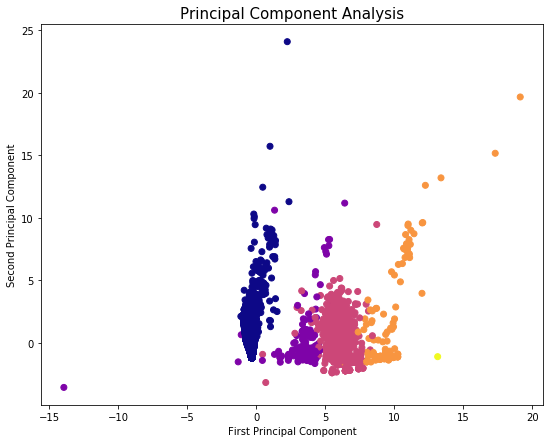

In [132]:
# Plot your components against each other

plt.figure(figsize=(9,7))
plt.scatter(x_pca[:,0],x_pca[:,1],c=current['target'], cmap='plasma')
plt.title('Principal Component Analysis', fontsize = 15)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
#plt.xlim(-1.5, 2.5)
#plt.ylim(-5, 5)

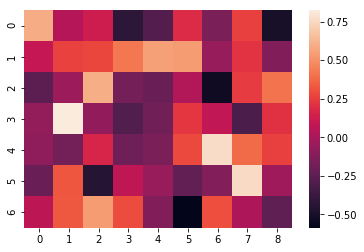

In [74]:
# This is neccessary to view the correlation of individual components to one another
pca.components_
sns.heatmap(pca.components_)

In [75]:
pca.components_

array([[ 0.59488783,  0.04027956,  0.12759332, -0.42011943, -0.28313881,
         0.19019122, -0.14403747,  0.25821628, -0.49793867],
       [ 0.09532953,  0.26852783,  0.27829208,  0.42119437,  0.5516389 ,
         0.5409599 , -0.05529967,  0.21943038, -0.12571027],
       [-0.24662273, -0.03814147,  0.60077679, -0.16612463, -0.20622785,
         0.03294759, -0.52684127,  0.24872963,  0.40761341],
       [-0.06535592,  0.82219627, -0.07463694, -0.28389632, -0.1809977 ,
         0.2304738 ,  0.08404799, -0.30594571,  0.21681543],
       [-0.07653427, -0.17211807,  0.17129085, -0.18588988, -0.14411428,
         0.28668382,  0.76221714,  0.38281234,  0.26484992],
       [-0.20540738,  0.32581778, -0.44647843,  0.07485487, -0.04803969,
        -0.23200551, -0.12082946,  0.75834567, -0.02969953],
       [ 0.06856746,  0.33065078,  0.53899359,  0.29675009, -0.12584951,
        -0.58649514,  0.30320526,  0.01624475, -0.23533358]])

In [76]:
pca.explained_variance_ratio_

array([0.17704812, 0.1694036 , 0.13397906, 0.11289036, 0.10366118,
       0.09837599, 0.07631782])

## PCA - Dionaea honeypot

We realised that performing PCA on data from all the honeypots was not ideal because some of the data gathered only apply to a specific honeypot and no to the other. Therefore, we focused on dionaea honeypot and identifing components there. To do that, we first found the most common honeypot for each ip, and the target used was again signature. Interestingly enough, most of the signatures are of the same kind, and there is a distinct cluster forming.

In [77]:
# find most common honeypot per ip
app = data[['src_ip', 'app']]
app_grouped = app.groupby('src_ip', as_index = False).agg({'app':lambda x: x.tolist()})
app_grouped['app'] = app_grouped['app'].apply(most_common)
app_grouped.head()
app_grouped['app'].value_counts()

dionaea     14973
cowrie       1346
amun          345
glastopf      224
rdphoney       74
conpot         21
Name: app, dtype: int64

In [78]:
dionaea_grouped = app_grouped.loc[app_grouped['app'] == "dionaea"]

In [79]:
dionaea_grouped.head()

,src_ip,app
0,1.0.139.35,dionaea
1,1.0.157.0,dionaea
2,1.0.182.29,dionaea
3,1.0.187.45,dionaea
4,1.0.190.251,dionaea


In [80]:
current_dionaea = pd.merge(dionaea_grouped, current, how = 'inner', on = 'src_ip')
current_dionaea.head()

,src_ip,app,target,dest_port_number,length_username,mean_time_difference,sd_time_difference,sensor_number,length_command,daily_frequency,length_password
0,1.0.139.35,dionaea,1,1,6.503028,41,11,1,170.090011,4,9.560111
1,1.0.157.0,dionaea,1,1,6.503028,52,17,1,170.090011,4,9.560111
2,1.0.182.29,dionaea,1,1,6.503028,3,27,1,170.090011,3,9.560111
3,1.0.187.45,dionaea,1,1,6.503028,1,2,1,170.090011,4,9.560111
4,1.0.190.251,dionaea,1,1,6.503028,41,11,1,170.090011,4,9.560111


In [81]:
scaler = StandardScaler()
current_pca_dionaea = current_dionaea.drop(["src_ip", "app"], axis = 1)
current_pca_dionaea.head()
scaler.fit(current_pca_dionaea)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [82]:
scaled_data = scaler.transform(current_pca_dionaea)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [83]:
pca = PCA(n_components=7)

In [84]:
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [85]:
x_pca = pca.transform(scaled_data)

In [86]:
scaled_data.shape

(14973, 9)

In [87]:
x_pca.shape

(14973, 7)

(-2, 2)

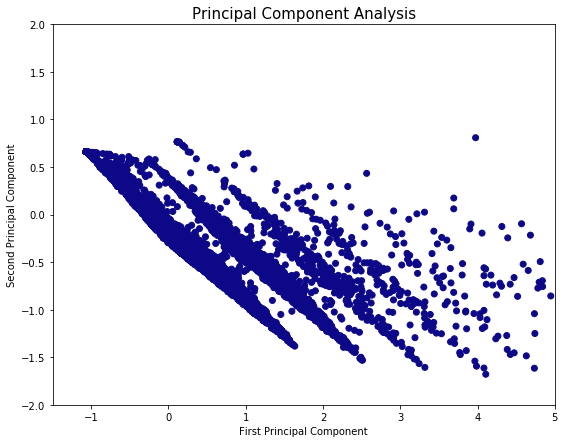

In [88]:
plt.figure(figsize=(9,7))
plt.scatter(x_pca[:,0],x_pca[:,1],c=current_dionaea['target'], cmap='plasma')
plt.title('Principal Component Analysis', fontsize = 15)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.xlim(-1.5, 5)
plt.ylim(-2, 2)

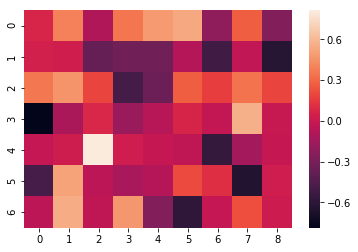

In [89]:
pca.components_
sns.heatmap(pca.components_)

In [90]:
sum(pca.explained_variance_ratio_[0:7])

0.8635999753507282

In [91]:
pca.components_

array([[ 0.06910615,  0.39177794, -0.09701007,  0.35129456,  0.4855705 ,
         0.53656886, -0.21061042,  0.27209234, -0.2585338 ],
       [ 0.04830831,  0.03429855, -0.3646445 , -0.32115438, -0.32382479,
        -0.08122165, -0.51297654, -0.0256849 , -0.62058043],
       [ 0.36025644,  0.45805074,  0.19323708, -0.49735505, -0.34477121,
         0.27397939,  0.16448447,  0.34382278,  0.19105251],
       [-0.7878458 , -0.10737464,  0.07788527, -0.17067092, -0.06759112,
         0.06826014, -0.01984905,  0.56826312, -0.00548071],
       [-0.01719664,  0.02438839,  0.81277968,  0.02574268, -0.00799461,
        -0.03384224, -0.56305132, -0.13955992, -0.01109123],
       [-0.48944348,  0.51528587, -0.04592768, -0.1243008 , -0.07651717,
         0.2123876 ,  0.11235877, -0.64266551,  0.02754432],
       [-0.04783417,  0.55362579, -0.03177762,  0.47214696, -0.25777099,
        -0.59154441, -0.0155954 ,  0.22446334,  0.01673731]])

## Random Forest - random danger data

In [92]:
# Import neccessary Random Forest libabries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [93]:

import random
rf_data = current.copy()
rf_data = rf_data[['src_ip','mean_time_difference','sd_time_difference','sensor_number','length_password']]

#adding new column (random data) which should be our output. Potentionally we will have this column
rf_data['danger'] = random.choices(population = [1,0],weights = [0.75,0.25], k = len(rf_data))
train = rf_data[:8000]
test = rf_data[8000:]



In [94]:
predictor_vars = ['mean_time_difference','sd_time_difference','sensor_number','length_password']
X, y = train[predictor_vars], train.danger

In [95]:
modelRandom = RandomForestClassifier(max_depth=25)
modelRandomCV = cross_val_score(modelRandom,X,y,cv = 5)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

In [96]:
modelRandomCV

array([0.72454716, 0.72642099, 0.721875  , 0.71857411, 0.71794872])

In [97]:
modelRandom = RandomForestClassifier(max_depth=25)
modelRandom.fit(X,y)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [98]:
predictions = modelRandom.predict(test[predictor_vars])
predictions

array([1, 1, 1, ..., 1, 1, 1])

In [99]:
test['predictions'] = predictions
test.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,src_ip,mean_time_difference,sd_time_difference,sensor_number,length_password,danger,predictions
8000,184.188.36.2,41,11,1,9.560111,1,1
8001,184.22.108.243,41,11,1,9.560111,0,1
8002,184.22.127.204,17,28,1,9.560111,1,1
8003,184.22.161.191,32,56,1,9.560111,1,1
8004,184.22.176.155,42,10,1,9.560111,1,1


In [100]:
def check(row):
    if row['danger'] == row['predictions']:
        return 'Correct'
    else:
        return 'Incorrect'
test['check'] = test.apply(check,axis = 1)

accuracy_total = len(test[test['check'] == 'Correct'])/len(test)
accuracy_total
#Hard to predict random data. Hence, low accuracy.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0.7171323611265724

In [101]:
danger = test[test['danger'] == 1]
danger_accuracy = len(danger[danger['check'] == 'Correct'])/len(danger)
danger_accuracy
#As we said, since data are random it's hard to predict outcomes. Especially for "danger"(since "danger" label is only about 25% of our training data)

0.927240461401952

[[ 172 2049]
 [ 492 6270]]


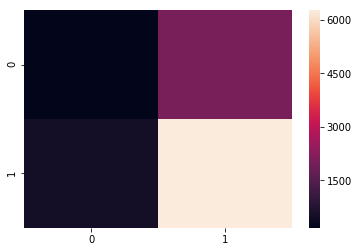

In [102]:
# Visualise classical Confusion Matrix
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(test.danger, predictions)
print(CM)

# Visualize it as a heatmap
import seaborn
seaborn.heatmap(CM)
plt.show()

In [133]:
# from sklearn.metrics import roc_curve, auc
# fpr, tpr, _ = roc_curve(test.danger,predictions)

# plt.clf()
# plt.plot(fpr, tpr)

# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

## Random Forest - tags

In [104]:
values = {"tags": "cloud"}
data.fillna(values, inplace = True)
data['tags'].value_counts()

cloud                         1460097
localnet,durham,honeynet         8332
localnet,durham,sciencedmz       8127
localnet,durham                   485
Name: tags, dtype: int64

In [105]:
def tags(row):
    if row == 'localnet,durham,honeynet' or row =='localnet,durham,sciencedmz' or row == 'localnet,durham':
        return 0
    if row == 'cloud':
        return 1

In [106]:
data['new_tags'] = data['tags'].apply(tags) 
data['new_tags'].value_counts()

new_data = data[['src_ip', 'new_tags']]

In [107]:
rftags = pd.merge(current, new_data, how = "inner", on = "src_ip")
rftags.drop_duplicates(subset = 'src_ip', inplace = True)
rftags['new_tags'].value_counts()

1    15514
0     1469
Name: new_tags, dtype: int64

In [108]:
from sklearn.model_selection import train_test_split
X = rftags[['mean_time_difference','sd_time_difference','sensor_number','length_password', 'length_username', "length_command", 'daily_frequency']]
y = rftags['new_tags']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

In [109]:
modelTags = RandomForestClassifier(max_depth = 25)
modelTags.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [110]:
predictions_tags = modelTags.predict(X_test)
predictions_tags
modelTags.feature_importances_

array([0.25523414, 0.28549536, 0.0492533 , 0.03883898, 0.0381046 ,
       0.01458855, 0.31848507])

[[  65  414]
 [  51 5075]]


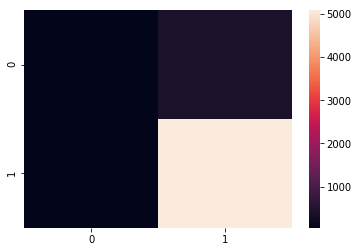

In [111]:
# Visualise classical Confusion Matrix
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, predictions_tags)
print(CM)

# Visualize it as a heatmap
import seaborn
seaborn.heatmap(CM)
plt.show()

In [112]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions_tags))

              precision    recall  f1-score   support

           0       0.56      0.14      0.22       479
           1       0.92      0.99      0.96      5126

   micro avg       0.92      0.92      0.92      5605
   macro avg       0.74      0.56      0.59      5605
weighted avg       0.89      0.92      0.89      5605

